In [1]:
# Before started, make usre you choose a colab RUNTIME with GPU

!git clone https://github.com/greyjoeyzhou/3pg_rnn.git

Cloning into '3pg_rnn'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 2), reused 22 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 94.67 KiB | 3.05 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import sys
import os
sys.path.append("./3pg_rnn/pytorch_3pg_rnn_single_point")
os.chdir("./3pg_rnn/pytorch_3pg_rnn_single_point")

In [3]:
from rnn_3pg import *

list_trainable = [
    'alpha', 'MaxCond', 'CoeffCond', 'fullCanAge',
]

def run_exp(
    fpath_setting,
    list_trainable=list_trainable,
    n_rep=1, # batch size of 1
    device='cuda',
    nodata=-9999.,
    lr=3e-4,
    n_epochs=80,
):

    # prepare data and convert to tensors:
    (
        initial,
        arr_day_length,
        arr_days_in_month,
        arr_site_paras,
        arr_input,
        arr_target,
        dict_initial_weights,
    ) = prepare(fpath_setting, list_trainable=list_trainable)

    arr_input = np.concatenate(
        [arr_input, arr_day_length, arr_days_in_month], axis=1
    )
    arr_input = np.concatenate(
        [arr_input, np.tile(arr_site_paras[None], [arr_input.shape[0], 1])],
        axis=1,
    )

    ts_input = torch.tensor(np.stack([arr_input] * n_rep, axis=0), device=device)
    ts_target = torch.tensor(np.stack([arr_target] * n_rep, axis=0), device=device)
    ts_initial = torch.tensor(np.array([initial] * n_rep), device=device)

    # build a model and print the initial trainable weights:
    model = RNN_3PG(initial_weights=dict_initial_weights).to(device=device)
    df_params_initial = inspect_params(model).loc[list_trainable]

    # plot the results by the default model
    ts_pred = model(ts_input, ts_initial)
    ts_pred_sub = agg_dbh_d13c(ts_pred)
    fig_initial = plot_result(ts_pred_sub, ts_target, nodata=nodata)

    # train the model
    criterion = MaskedMSESelectedVarsLoss(nodata=nodata)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dict_loss = train(
        model=model,
        inputs={'input': ts_input, 'h0': ts_initial},
        target=ts_target,
        criterion=criterion,
        optimizer=optimizer,
        n_epochs=n_epochs,
    )

    plt.figure()
    df_res = pd.DataFrame({'loss': dict_loss})
    df_res['loss'].plot()

    # print the calibrated parameters
    df_params_calibrated = inspect_params(model).loc[list_trainable]

    df_params = pd.concat([df_params_initial, df_params_calibrated], axis=1)

    # plot the results by the calibrated model
    ts_pred = model(ts_input, ts_initial)
    ts_pred_sub = agg_dbh_d13c(ts_pred)

    fig_calibrated = plot_result(ts_pred_sub, ts_target, nodata=nodata)

    return model, df_params, fig_initial, fig_calibrated, ts_input, ts_initial, ts_pred_sub, ts_target


Epoch [10/80], Loss: 5.9323
Epoch [20/80], Loss: 3.5847
Epoch [30/80], Loss: 3.5472
Epoch [40/80], Loss: 2.8490
Epoch [50/80], Loss: 2.6515
Epoch [60/80], Loss: 2.6266
Epoch [70/80], Loss: 2.6141
Epoch [80/80], Loss: 2.6085


,value,grad,value,grad
alpha,0.0653,NaN,0.059612,"tensor(-55.3422, device='cuda:0')"
MaxCond,0.0135,NaN,0.013075,"tensor(8.9610, device='cuda:0')"
CoeffCond,0.0800,NaN,0.08635,"tensor(31.9713, device='cuda:0')"
fullCanAge,27.0000,NaN,27.006384,"tensor(0.0341, device='cuda:0')"


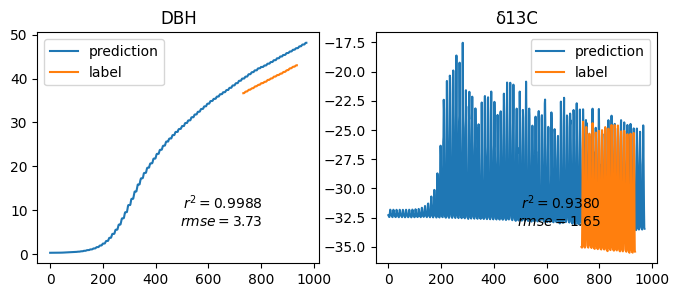

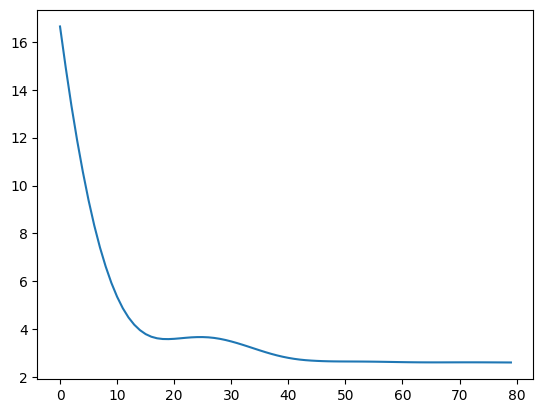

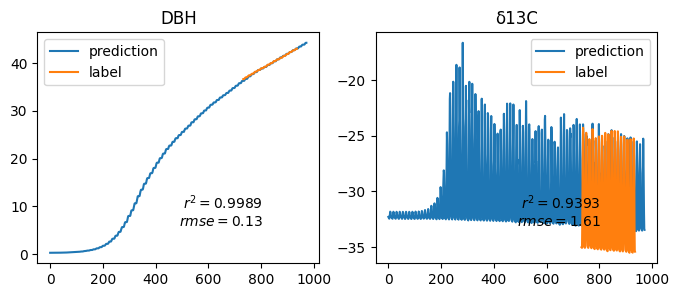

In [4]:
fpath_setting = "data_files/exp.yaml"
model, df_params, fig_initial, fig_calibrated, ts_input, ts_initial,ts_pred_sub, ts_target = run_exp(fpath_setting)
df_params